In [21]:
import os
import re

import pandas as pd

import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
df_train = pd.read_csv('df_train.csv', index_col=0)
df_test = pd.read_csv('df_test.csv', index_col=0)

In [3]:
X_train = df_train[['text']]
y_train = df_train['label']

In [4]:
X_test = df_test[['text']]
y_test = df_test['label']

In [5]:
class CreateFeatures(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, text_col='text'):
        # save the features list internally in the class
        self.text_col = text_col
        
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        
        X_new = X.copy()
        
        X_new['text_len'] = self._feat_text_len(X_new)
        
        X_new['is_number'] = self._feat_is_number(X_new)
        
        X_new['final_colon'] = self._feat_final_colon(X_new)
        
        X_new['has_unit'] = self._feat_has_unit(X_new)
        
        X_new['digit_ratio'] = self._feat_digit_ratio(X_new)        
        
        return X_new
    
    
    def _feat_text_len(self, X, y = None):
        
        new_feat = X[self.text_col].copy().str.len().fillna(0)
        
        return new_feat
    
    def _feat_is_number(self, X, y = None):
        
        new_feat = (pd.to_numeric((X[self.text_col].copy()
                                   .str.replace("*", "", regex=False)),
                                  errors='coerce')
                    .notna().astype('int8'))
        
        return new_feat
    
    def _feat_final_colon(self, X, y = None):
        
        new_feat = (X[self.text_col].copy()
                    .str.rstrip().str[-1:].eq(':').astype('int8'))
        
        return new_feat
    
    def _feat_has_unit(self, X, y = None):
        
        unit_name_list = [r'millimeter', r'centimeter', r'meter', r'inch',
                          r'inche', r'feet', r'yard', r'liter', r'gallon',
                          r'gram', r'milligram', r'kilogram', r'tonne',
                          r'pound', r'ounce']
        
        unit_symbol_list = [r'mm', r'cm', r'm', r'ft', r'yd', r'ltr', r'in',
                            r'gal', r'g', r'mg', r'kg', r't', r'lb', r'oz']
        
        unit_list = unit_name_list + unit_symbol_list
        
        regex_pat_list = [r'\d\s*' + unit + r's?\b' for unit in unit_list]
        regex_pat_str = r'|'.join(regex_pat_list)
        
        new_feat = (X[self.text_col].copy()
                    .str.contains(regex_pat_str, regex=True).fillna(False).astype('int8'))
        
        return new_feat
    
    def _feat_digit_ratio(self, X, y = None):
        
        X_text_original = X[self.text_col].copy()
        
        new_feat = (X_text_original.str.count('\d')
                    .div(X_text_original.str.len())
                    .fillna(0))
        
        return new_feat
    

In [6]:
pipe_preprocessing = Pipeline([('create_feats', CreateFeatures(text_col='text'))])

In [7]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, text_col='text'):
        self.text_col = text_col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Drop the column containing the original text
        return X.drop(columns=self.text_col)
    


In [8]:
pipe_selector = Pipeline([('select_feats', Selector(text_col='text'))])

[Multiclass classifiers](https://scikit-learn.org/stable/modules/multiclass.html)

In [9]:
pipe_clf = Pipeline([('clf', ExtraTreesClassifier(n_estimators=25, random_state=0))])

In [10]:
pipe = Pipeline([('create_feats', pipe_preprocessing),
                 ('select_feats', pipe_selector),
                 ('clf', pipe_clf)])

In [11]:
# Initialize X
X_train = df_train[['text']]
pipe.fit(X_train, y_train)

Pipeline(steps=[('create_feats',
                 Pipeline(steps=[('create_feats', CreateFeatures())])),
                ('select_feats',
                 Pipeline(steps=[('select_feats', Selector())])),
                ('clf',
                 Pipeline(steps=[('clf',
                                  ExtraTreesClassifier(n_estimators=25,
                                                       random_state=0))]))])

In [12]:
y_pred = pipe.predict(X_test)

In [13]:
y_pred

array(['answer', 'question', 'question', ..., 'question', 'answer',
       'question'], dtype=object)

[Performance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [25]:
label_order = ['question', 'answer', 'header', 'other']

In [26]:
confusion_matrix(y_test, y_pred, labels=label_order)

array([[1004,   52,    9,   12],
       [ 302,  468,   11,   40],
       [ 100,   12,    9,    1],
       [  80,  130,    8,   94]], dtype=int64)

In [16]:
cf_matrix = confusion_matrix(y_test, y_pred, labels=label_order)
cf_matrix_df = pd.DataFrame(data=cf_matrix, index=label_order, columns=label_order)

In [17]:
cf_matrix_df

,question,answer,header,other
question,1004,52,9,12
answer,302,468,11,40
header,100,12,9,1
other,80,130,8,94


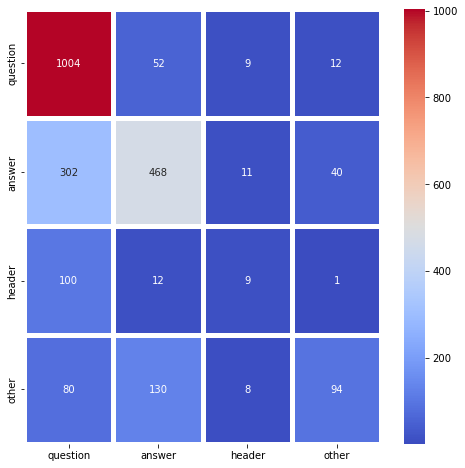

In [20]:
plt.figure(figsize=(8,8))
sns.heatmap(data=cf_matrix_df, annot=True, fmt="d",cmap='coolwarm', linewidths=5)
plt.show()

In [19]:
print(classification_report(y_test, y_pred, labels=label_order))

              precision    recall  f1-score   support

    question       0.68      0.93      0.78      1077
      answer       0.71      0.57      0.63       821
      header       0.24      0.07      0.11       122
       other       0.64      0.30      0.41       312

    accuracy                           0.68      2332
   macro avg       0.57      0.47      0.48      2332
weighted avg       0.66      0.68      0.64      2332

